In [1]:
import sys
sys.path.insert(0, '../')
from bandits.linucb import TFLinUCB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tensorflow as tf
from sklearn.decomposition import PCA
if tf.test.gpu_device_name(): 
    print('Default GPU Device:',tf.test.gpu_device_name())
else:
    print("Installing GPU version of TF")

Default GPU Device: /device:GPU:0


In [2]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
tf.executing_eagerly()


True

# Data reading and buffers creation

In [4]:
def read_data():
    items_features = pd.read_csv('../processed_data/item_features.csv')
    items_meta = pd.read_csv('../processed_data/meta_features.csv')
    users_ratings = pd.read_csv('../../../movilens/rating.csv')
    return items_features, items_meta, users_ratings

In [5]:
items_features, items_meta, users_ratings = read_data()

In [6]:
items = items_meta['movieId'].values

In [7]:
users_ratings = users_ratings[users_ratings['rating']>=3.5]

In [8]:
users_ratings['rating'] = 1

In [9]:
grouped_ratings = users_ratings.groupby('userId')['movieId'].apply(list).apply(len)>1

In [10]:
grouped_ratings.value_counts()

True     138248
False       114
Name: movieId, dtype: int64

In [11]:
grouped_ratings = grouped_ratings.to_frame()
users_to_use = grouped_ratings[grouped_ratings['movieId']==True].reset_index()['userId'].values

In [12]:
users_ratings = users_ratings[users_ratings['userId'].isin(users_to_use)]

In [13]:
users_ratings['timestamp'] = pd.to_datetime(users_ratings['timestamp'])
users_ratings.sort_values(by='timestamp', inplace=True)

In [14]:
users_ratings = users_ratings.reset_index().drop(columns='index')

In [15]:
users_ratings.head(2)

,userId,movieId,rating,timestamp
0,28507,1176,1,1995-01-09 11:46:44
1,131160,47,1,1995-01-09 11:46:49


In [16]:
items_features.head(2)

,movieId,Action,Adult,Adventure,Animation,Biography,Children,Comedy,Crime,Documentary,...,unknown,1891-1916,1916-1941,1941-1966,1966-1991,1991-2016,movie,short,tv,video
0,1,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,1,1,0,0,0
1,2,0,0,1,0,0,1,1,0,0,...,0,0,0,0,0,1,1,0,0,0


In [17]:
items_meta.head(2)

,Unnamed: 0,movieId,title,genres,tags,imdbId,primaryName,titleType,isAdult,startYear,averageRating,numVotes,counts
0,0,1,Toy Story (1995),"['Children', 'Adventure', 'Comedy', 'Animation...","['3d', 'action', 'adventure', 'affectionate', ...",tt0114709,"['Tim Allen', 'John Ratzenberger', 'Wallace Sh...",movie,0,1991-2016,8.3,872273,49695.0
1,1,2,Jumanji (1995),"['Children', 'Adventure', 'Comedy', 'Family', ...","['action', 'adventure', 'animal movie', 'anima...",tt0113497,"['Bonnie Hunt', 'Bebe Neuwirth', 'Adam Hann-By...",movie,0,1991-2016,7.0,302198,22243.0


In [18]:
items_meta['startYear'].value_counts()

1991-2016    16809
1966-1991     5754
1941-1966     3231
1916-1941     1419
1891-1916       65
Name: startYear, dtype: int64

In [19]:
items_meta['genres'] = items_meta['genres'].apply(lambda x: json.loads(x.replace("'",'"')))

In [20]:
class UserHistBuffer:
    def __init__(self, n_max=10):
        self.user_dict = {}
        self.n_max = n_max
    
    def add(self, user_id, item_id):
        user_history = self.user_dict.get(user_id, [])
        user_history.append(item_id)
        if not user_history:
            self.user_dict.update({user_id:user_history})
        else:
            user_history = user_history[-self.n_max:]
            self.user_dict.update({user_id:user_history})
    def get(self, user_id, default=[]):
        return self.user_dict.get(user_id, default)

In [21]:
from sklearn.base import TransformerMixin

class FrequencyTransformer(TransformerMixin):
    def __init__(self, scale=False, classes=None):
        self.scale = scale
        self.classes_ = classes
        self.fitted = False

    def fit(self, X):
        if self.classes_ is None:
            self.classes_ = np.unique(np.hstack(X))
        self.fitted = True
        return self

    def to_numpy(self, arr):
        if isinstance(arr[0], list):
            arr = [np.array(i) for i in arr]

    def transform(self, X):
        assert self.fitted, 'You should use fit before using transform.'
        self.to_numpy(X)
        count_table = np.zeros(shape=(len(X), len(self.classes_)), dtype='float16')
        lens = [len(i) for i in X]
        maxlen = max(lens)
        broadcasted = np.full((len(X), maxlen), dtype='object', fill_value='unk')
        mask = np.arange(maxlen) < np.array(lens)[:, None]
        broadcasted[mask] = np.concatenate(X)
        for idx, class_ in enumerate(self.classes_):
            count_table[:, idx] = (broadcasted == class_).sum(axis=1)
        if self.scale:
            count_table = count_table / count_table.sum(axis=1).reshape(-1, 1)
            count_table[~np.isfinite(count_table)] = 0
        return count_table


In [22]:
class UserFeatureBuffer:
    def __init__(self, items_meta, items_column, feature_order, feature_shape=None):
        self.items_meta = items_meta
        self.items_column = items_column
        self.feature_columns = feature_order
        self.feature_shape = feature_shape
        self.unique_in_cols = {}
        for column in self.feature_columns:
            try:
                self.unique_in_cols.update({column:self.items_meta[column].unique()})
            except:
                self.unique_in_cols.update({column:np.unique(np.hstack(items_meta[column].values))})
        
    def transform(self, user_history, return_names=False, scale=True):
        user_history = np.array(user_history)
        if user_history.size!=0:
            subset = items_meta[items_meta[self.items_column].isin(user_history)]
            result = np.array([])
            names = np.array([])
            for column in self.feature_columns:
                classes = self.unique_in_cols.get(column)
                to_transform = np.hstack(subset[column].values).reshape(1, -1)
                transformer = FrequencyTransformer(classes=classes, scale=scale)
                tmp_result = transformer.fit_transform(to_transform)
                result = np.append(result, tmp_result)
                names = np.append(names, classes)
            if return_names:
                return result, names
            else:
                return result
        elif self.feature_shape:
            return np.zeros(shape=(self.feature_shape,))
        else:
            return []

In [23]:
len(users_ratings)

12195452

### testing created buffers

In [24]:
import gc

In [25]:
user_hist_buffer = UserHistBuffer()

In [26]:
userId = 1
test_hist = users_ratings[users_ratings['userId']==userId].movieId.values[:10]
new_item = users_ratings[users_ratings['userId']==userId].movieId.values[11]

In [27]:
for movieId in test_hist:
    user_hist_buffer.add(user_id=userId, item_id=movieId)
    

In [28]:
test_hist, user_hist_buffer.get(userId)

(array([ 924,  919, 2683, 1584, 1079, 2959,  337, 3996,  151,  112]),
 [924, 919, 2683, 1584, 1079, 2959, 337, 3996, 151, 112])

In [29]:
user_feature_buffer = UserFeatureBuffer(items_meta=items_meta, items_column='movieId', feature_order=['genres','startYear','titleType'])

In [30]:
user_feature_buffer.unique_in_cols

{'genres': array(['Action', 'Adult', 'Adventure', 'Animation', 'Biography',
        'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
        'Fantasy', 'Film-Noir', 'History', 'Horror', 'IMAX', 'Music',
        'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
        'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western',
        'unknown'], dtype='<U11'),
 'startYear': array(['1991-2016', '1966-1991', '1941-1966', '1916-1941', '1891-1916'],
       dtype=object),
 'titleType': array(['movie', 'tv', 'video', 'short'], dtype=object)}

In [31]:
u_feature, names = user_feature_buffer.transform(test_hist, return_names=True)

In [32]:
u_feature, names

(array([0.13891602, 0.        , 0.16662598, 0.        , 0.027771  ,
        0.027771  , 0.08331299, 0.08331299, 0.        , 0.16662598,
        0.027771  , 0.05554199, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.027771  , 0.027771  , 0.        ,
        0.        , 0.05554199, 0.05554199, 0.        , 0.        ,
        0.        , 0.027771  , 0.027771  , 0.        , 0.        ,
        0.70019531, 0.19995117, 0.        , 0.09997559, 0.        ,
        1.        , 0.        , 0.        , 0.        ]),
 array(['Action', 'Adult', 'Adventure', 'Animation', 'Biography',
        'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
        'Fantasy', 'Film-Noir', 'History', 'Horror', 'IMAX', 'Music',
        'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
        'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western',
        'unknown', '1991-2016', '1966-1991', '1941-1966', '1916-1941',
        '1891-1916', 'movie', 'tv', 'video',

In [33]:
i_features = items_features[items_features.columns[1:]].values

In [34]:
u_feature.shape, i_features.shape

((39,), (27278, 39))

In [35]:
(i_features*u_feature).shape

(27278, 39)

In [36]:
del u_feature, names, user_feature_buffer, test_hist, user_hist_buffer
gc.collect();

# Creation of simulators and training loop

In [37]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from time import time
sns.set()
%matplotlib inline
def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

In [38]:
class Simulator:
    def __init__(self, data, user_column, item_column):
        self.data = data
        self.user_column = user_column
        self.item_column = item_column
        
    def generate(self):
        for timestamp in range(len(self.data)):
            sample = self.data.loc[timestamp]
            user_id = sample[self.user_column]
            item_id = sample[self.item_column]
            yield user_id, item_id

In [39]:
def outer_feature(x,y):
    if len(y.shape)==1:
        shape = x.shape[1]*y.shape[0]
    else:
        shape = x.shape[1]*y.shape[1]
    res = np.apply_along_axis(np.outer, 0, x, y)
    return res.reshape(x.shape[0],shape)

In [40]:
def inner_feature(x,y):
    return x*y

In [41]:
def concat_feature(x,y):
    shape = y.shape[1] if len(y.shape)>1 else y.shape[0]
    y = np.broadcast_to(y, shape=(x.shape[0],shape))
    return np.concatenate([x,y],axis=1)

In [42]:
def define_buffers(users_ratings,items_meta,feature_shape, use_bias=True):
    generator = Simulator(users_ratings, user_column='userId', item_column='movieId').generate()
    user_hist_buffer = UserHistBuffer()
    user_feature_buffer = UserFeatureBuffer(items_meta, items_column='movieId', feature_order=['genres','startYear','titleType'], feature_shape=feature_shape-1 if use_bias else feature_shape)
    return generator, user_hist_buffer,user_feature_buffer

In [43]:
i_features = np.concatenate([i_features, np.array([1 for i in range(i_features.shape[0])]).reshape(-1,1)], axis=1)

In [44]:
feature_shape = i_features.shape[1]

In [45]:
random_seed = 6
batch_metrics = 100
np.random.seed(random_seed)

In [46]:
def train(generator,user_feature_buffer,user_hist_buffer,
          feature_processing,i_features, items,
          alpha=0.1, use_bias=True):
    
    start = time()
    counter = 0
    bandit = None
    reward = []
    for user_id, item_id in tqdm.tqdm(generator):
        u_hist = user_hist_buffer.get(user_id)
        u_feature = user_feature_buffer.transform(u_hist, return_names=False)
        if use_bias:
            u_feature = np.append(u_feature,[1])
        batch_feature = feature_processing(i_features, u_feature).astype('float32')
        if counter==0:
            bandit = TFLinUCB(context_dimension=batch_feature.shape[1],items=items,alpha=alpha)
        action, item, score = bandit.predict(batch_feature)
        feature = batch_feature[action]
        if item==item_id:
            bandit.update(action=action,context=feature,reward=1.0)
            reward.append(1)
        else:
            bandit.update(action=action,context=feature,reward=0.0)
            reward.append(0)
        user_hist_buffer.add(user_id, item_id)
        if counter%batch_metrics==0 and counter!=0:
            clear_output(True)
            plt.plot(moving_average(reward), label='moving reward')
            plt.ylabel('AVG reward')
            plt.xlabel('Steps')
            plt.title('Moving reward')
            plt.show()
            print('Average reward for {0} step : {1}'.format(counter, np.mean(reward[counter - batch_metrics:counter])))
        counter+=1

    end = time()
    print('Training took : {} min'.format((end-start)/60))
    return bandit, reward

In [47]:
def check_params(bandit):
    b_parameter = np.copy(bandit.b.numpy())
    b_parameter = b_parameter.reshape(b_parameter.shape[0], b_parameter.shape[1])
    res = np.apply_along_axis(axis=1, arr=b_parameter, func1d=lambda x: np.all(x==0))
    not_updated = res.astype(int).sum()
    updated = len(res)-not_updated
    print('Number of updated items : {}'.format(updated))
    print('Number of not-updated items : {}'.format(not_updated))

## Experiments to show that number of items in model matters

In [48]:
sample_users = users_ratings[:500000]

#### Experiments with all items

#### experiment 1, using all items and inner product as feature processing

In [49]:
generator, user_hist_buffer,user_feature_buffer = define_buffers(sample_users, items_meta, feature_shape)

In [50]:
feature_processing = inner_feature


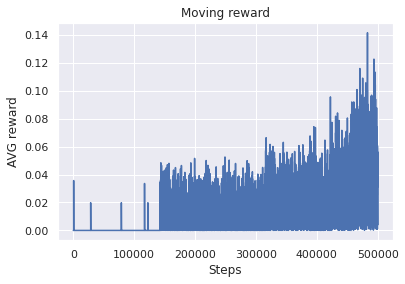

499905it [4:06:23, 26.30it/s]

Average reward for 499900 step : 0.03


500000it [4:06:26, 33.81it/s]

Training took : 246.44115093549092 min


In [54]:
bandit_all_items, reward_all_items = train(generator,user_feature_buffer,user_hist_buffer,
          feature_processing,i_features, items,
          alpha=0.1)

In [55]:
with open('rewards_all_items_inner.npy', 'wb') as f:
    np.save(f, np.array(reward_all_items))

In [56]:
print('Mean reward for run : {}'.format(np.mean(reward_all_items)))
print('Mean CTR for run : {}%'.format(np.mean(reward_all_items)*100))

Mean reward for run : 0.008744
Mean CTR for run : 0.8744%


In [57]:
check_params(bandit_all_items)

Number of updated items : 14
Number of not-updated items : 27264


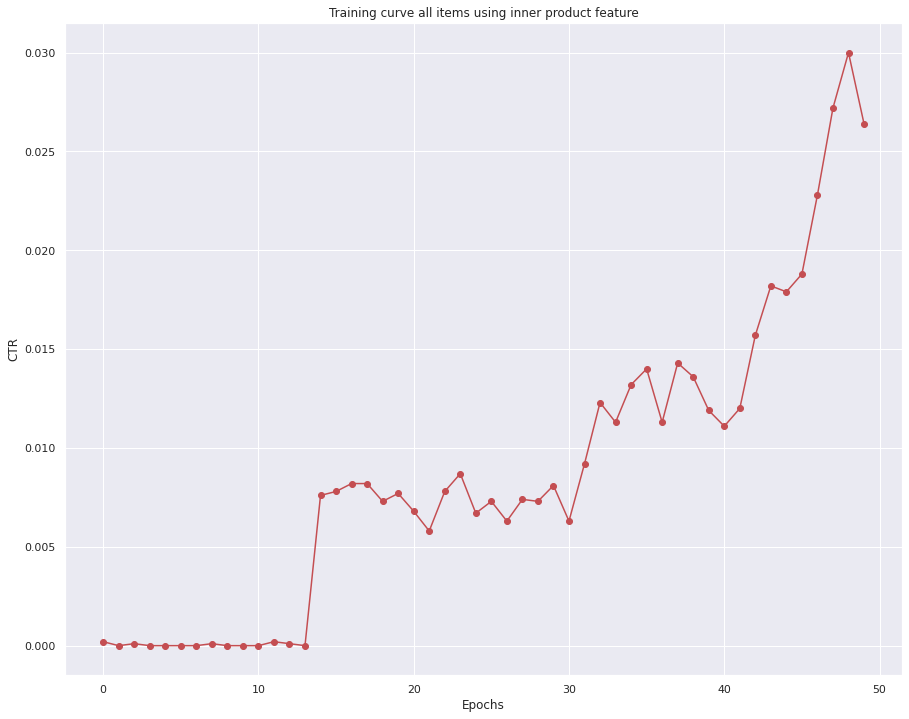

In [79]:
step = 10000
train_curve_inner_all = [np.mean(reward_all_items[i:i+step]) for i in range(0,len(reward_all_items)+step, step)]
plt.figure(figsize=(15,12))
plt.plot(train_curve_inner_all, 'or')
plt.plot(train_curve_inner_all, 'r')
plt.title('Training curve all items using inner product feature')
plt.ylabel('CTR')
plt.xlabel('Epochs');

#### experiment 2, using all items and concat as feature processing

In [52]:
generator, user_hist_buffer,user_feature_buffer = define_buffers(sample_users, items_meta, feature_shape)

In [53]:
feature_processing = concat_feature

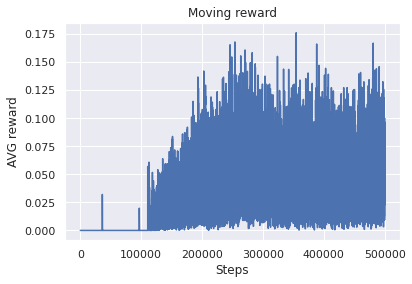

499903it [10:19:05, 10.50it/s]

Average reward for 499900 step : 0.05


500000it [10:19:12, 13.46it/s]

Training took : 619.2071459213893 min


In [60]:
bandit_all_items_concat, reward_all_items_concat = train(generator,user_feature_buffer,user_hist_buffer,
          feature_processing,i_features, items,
          alpha=0.1)

In [61]:
with open('rewards_all_items_concat.npy', 'wb') as f:
    np.save(f, np.array(reward_all_items_concat))

In [62]:
print('Mean reward for run : {}'.format(np.mean(reward_all_items_concat)))
print('Mean CTR for run : {}%'.format(np.mean(reward_all_items_concat)*100))

Mean reward for run : 0.031112
Mean CTR for run : 3.1112%


In [63]:
check_params(bandit_all_items_concat)

Number of updated items : 15
Number of not-updated items : 27263


51


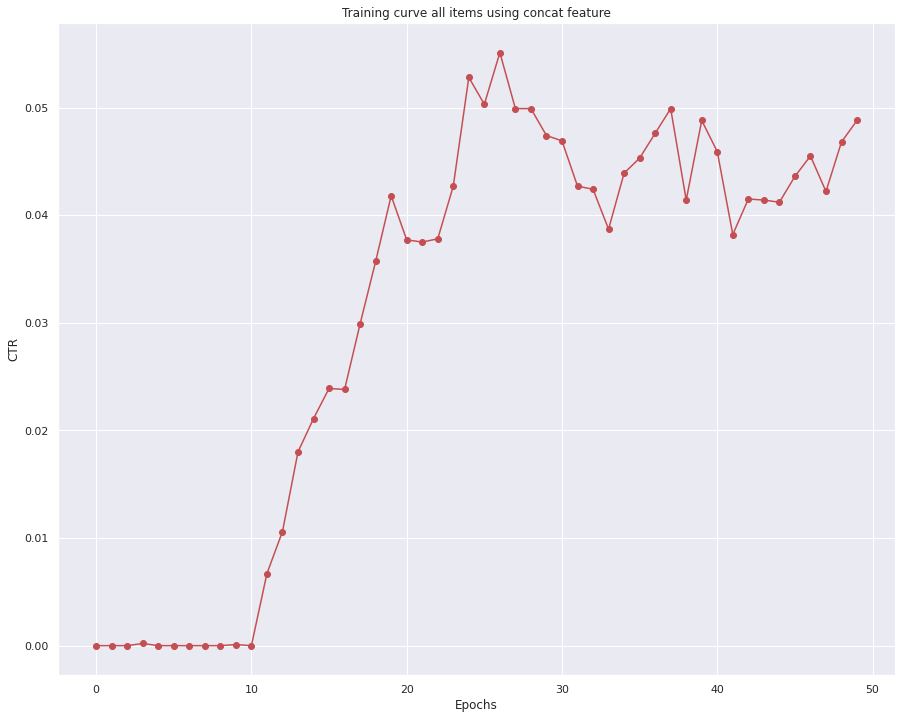

In [78]:
step = 10000
train_curve_concat_all = [np.mean(reward_all_items_concat[i:i+step]) for i in range(0,len(reward_all_items_concat)+step, step)]
plt.figure(figsize=(15,12))
plt.plot(train_curve_concat_all, 'or')
plt.plot(train_curve_concat_all, 'r')
plt.title('Training curve all items using concat feature')
plt.ylabel('CTR')
plt.xlabel('Epochs');

#### experiment 3, using all items and online pca on outer product as feature processing

In [49]:
items_pca = PCA(n_components=2)
feature_shape = i_features.shape[1]-1
transformed_features = items_pca.fit_transform(i_features[:,:-1]).astype('float32')

In [50]:
feature_processing = outer_feature

In [51]:
generator, user_hist_buffer,user_feature_buffer = define_buffers(sample_users, items_meta, feature_shape, use_bias=False)

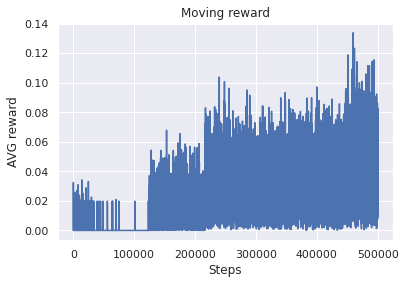

499902it [10:50:40,  9.26it/s]

Average reward for 499900 step : 0.04


500000it [10:50:47, 12.80it/s]

Training took : 650.7922775705655 min


In [52]:
bandit_all_items_outer_pca, reward_all_items_outer_pca = train(generator,user_feature_buffer,user_hist_buffer,
          feature_processing,transformed_features, items,
          alpha=0.1, use_bias=False)

In [53]:
with open('reward_all_items_outer_pca.npy', 'wb') as f:
    np.save(f, np.array(reward_all_items_outer_pca))

In [54]:
print('Mean reward for run : {}'.format(np.mean(reward_all_items_outer_pca)))
print('Mean CTR for run : {}%'.format(np.mean(reward_all_items_outer_pca)*100))

Mean reward for run : 0.018836
Mean CTR for run : 1.8836%


In [55]:
check_params(bandit_all_items_outer_pca)

Number of updated items : 15
Number of not-updated items : 27263


/home/volodymyr/envs/linucb_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/volodymyr/envs/linucb_env/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


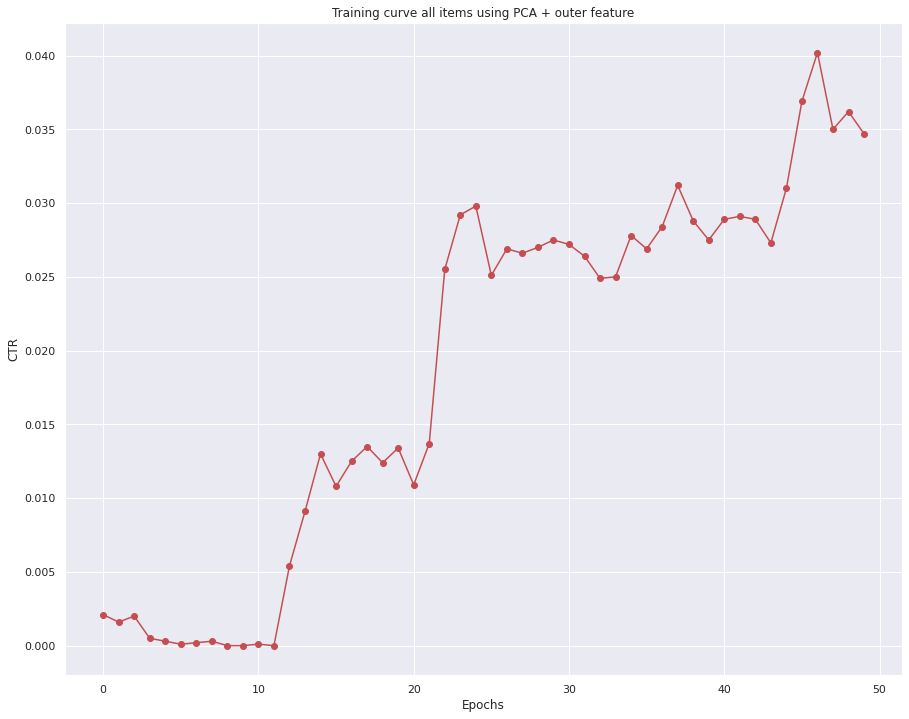

In [56]:
step = 10000
train_curve_outer_pca = [np.mean(reward_all_items_outer_pca[i:i+step]) for i in range(0,len(reward_all_items_outer_pca)+step, step)]
plt.figure(figsize=(15,12))
plt.plot(train_curve_outer_pca, 'or')
plt.plot(train_curve_outer_pca, 'r')
plt.title('Training curve all items using PCA + outer feature')
plt.ylabel('CTR')
plt.xlabel('Epochs');

#### comparison of 3 experiments

In [77]:
def plot_charts(data, colours=None, with_points=False,legend_names=None, figsize=(15,12)):
    plt.figure(figsize=figsize)
    for c,arr in enumerate(data):
        plt.plot(arr, colours[c] if colours else None)
        if with_points:
            plt.plot(arr, 'o'+colours[c] if colours else 'o')
        plt.xlabel('Epochs')
        plt.ylabel('CTR')
    if legend_names:
        plt.legend(legend_names)
    plt.title('Comparison of {} experiments'.format(len(data)))


In [69]:
rewards_all_items_concat = np.load('rewards_all_items_concat.npy')
rewards_all_items_inner = np.load('rewards_all_items_inner.npy')
reward_all_items_outer_pca = np.load("reward_all_items_outer_pca.npy")

In [70]:
def convert_to_epochs(arr, step=10000):
    return [np.mean(arr[i:i+step]) for i in range(0,len(arr)+step, step)]


In [71]:
rewards_all_items_concat = convert_to_epochs(rewards_all_items_concat)
rewards_all_items_inner = convert_to_epochs(rewards_all_items_inner)
reward_all_items_outer_pca = convert_to_epochs(reward_all_items_outer_pca)

/home/volodymyr/envs/linucb_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/volodymyr/envs/linucb_env/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [72]:
data = [rewards_all_items_inner, rewards_all_items_concat, reward_all_items_outer_pca]
colours = ['g','r','b']
legend_names = ['All items + inner feature', 'All items + concat feature', 'All items + PCA on outer feature']

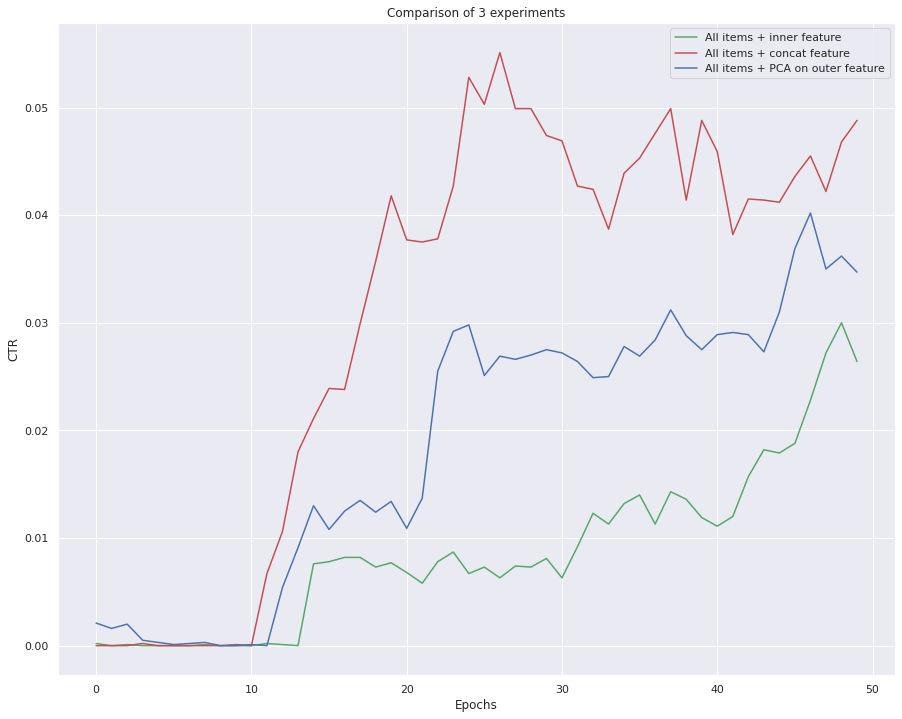

In [78]:
plot_charts(data, colours, False, legend_names)

### Experiments using only a part of items

In [50]:
idx_1000 = np.random.choice(range(len(items)), 1000)
items_1000 = items[idx_1000]
i_features_1000 = i_features[idx_1000]

#### experiment 1 : 1000 random items + inner feature

In [51]:
feature_shape = i_features_1000.shape[1]
generator, user_hist_buffer,user_feature_buffer = define_buffers(sample_users, items_meta, feature_shape)
feature_processing = inner_feature

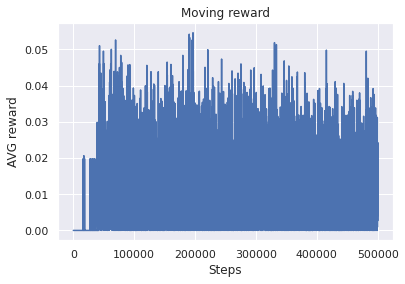

499938it [56:19, 116.87it/s]

Average reward for 499900 step : 0.01


500000it [56:20, 147.92it/s]

Training took : 56.33513240416845 min


In [52]:
bandit_1000_items_inner, reward_1000_items_inner = train(generator,user_feature_buffer,user_hist_buffer,
          feature_processing,i_features_1000, items_1000,
          alpha=0.1, use_bias=True)

In [57]:
with open('rewards_1000_items_inner.npy', 'wb') as f:
    np.save(f, np.array(reward_1000_items_inner))

In [53]:
print('Mean reward for run : {}'.format(np.mean(reward_1000_items_inner)))
print('Mean CTR for run : {}%'.format(np.mean(reward_1000_items_inner)*100))

Mean reward for run : 0.006096
Mean CTR for run : 0.6096%


In [54]:
check_params(bandit_1000_items_inner)

Number of updated items : 6
Number of not-updated items : 994


/home/volodymyr/envs/linucb_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/volodymyr/envs/linucb_env/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


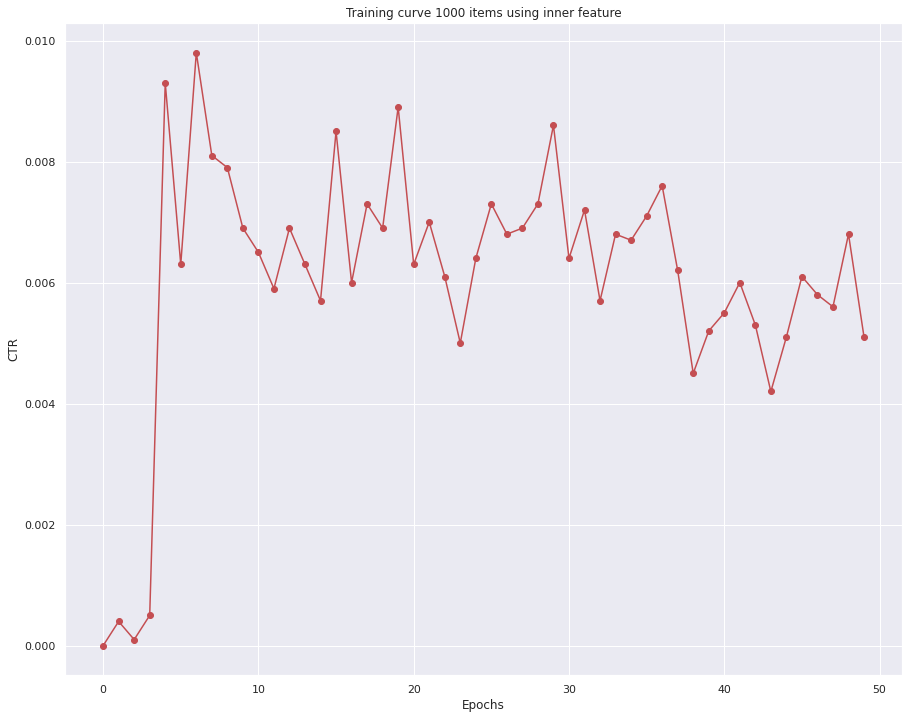

In [55]:
step = 10000
train_curve_inner_1000 = [np.mean(reward_1000_items_inner[i:i+step]) for i in range(0,len(reward_1000_items_inner)+step, step)]
plt.figure(figsize=(15,12))
plt.plot(train_curve_inner_1000, 'or')
plt.plot(train_curve_inner_1000, 'r')
plt.title('Training curve 1000 items using inner feature')
plt.ylabel('CTR')
plt.xlabel('Epochs');

#### experiment 2 : 1000 random items and + concat feature

In [51]:
feature_shape = i_features_1000.shape[1]
generator, user_hist_buffer,user_feature_buffer = define_buffers(sample_users, items_meta, feature_shape)
feature_processing = concat_feature

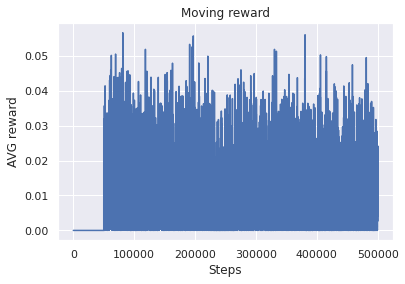

499916it [1:12:13, 98.14it/s] 

Average reward for 499900 step : 0.01


500000it [1:12:14, 115.35it/s]

Training took : 72.24312889973322 min


In [52]:
bandit_1000_items_concat, reward_1000_items_concat = train(generator,user_feature_buffer,user_hist_buffer,
          feature_processing,i_features_1000, items_1000,
          alpha=0.1, use_bias=True)

In [53]:
print('Mean reward for run : {}'.format(np.mean(reward_1000_items_concat)))
print('Mean CTR for run : {}%'.format(np.mean(reward_1000_items_concat)*100))

Mean reward for run : 0.006008
Mean CTR for run : 0.6008%


In [54]:
check_params(bandit_1000_items_concat)

Number of updated items : 5
Number of not-updated items : 995


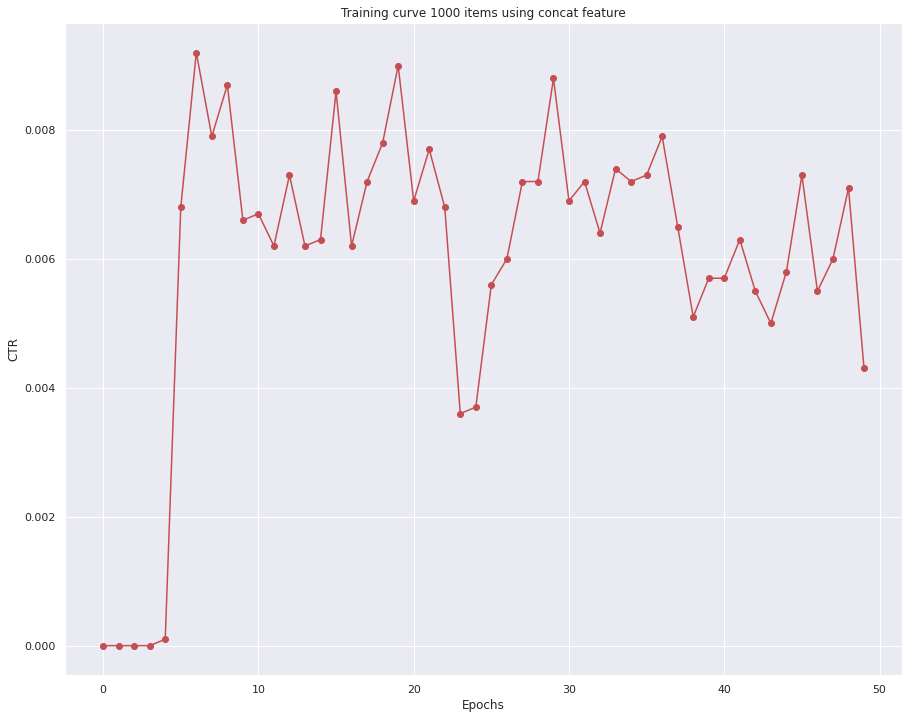

In [56]:
step = 10000
train_curve_concat_1000 = [np.mean(reward_1000_items_concat[i:i+step]) for i in range(0,len(reward_1000_items_concat)+step, step)]
plt.figure(figsize=(15,12))
plt.plot(train_curve_concat_1000, 'or')
plt.plot(train_curve_concat_1000, 'r')
plt.title('Training curve 1000 items using concat feature')
plt.ylabel('CTR')
plt.xlabel('Epochs');

In [57]:
with open('rewards_1000_items_concat.npy', 'wb') as f:
    np.save(f, np.array(reward_1000_items_concat))

#### experiment 3 : 1000 random items + outer product

In [55]:
items_pca = PCA(n_components=2)
feature_shape = i_features_1000.shape[1]-1
transformed_features = items_pca.fit_transform(i_features_1000[:,:-1]).astype('float32')
generator, user_hist_buffer,user_feature_buffer = define_buffers(sample_users, items_meta, feature_shape, use_bias=False)
feature_processing = outer_feature

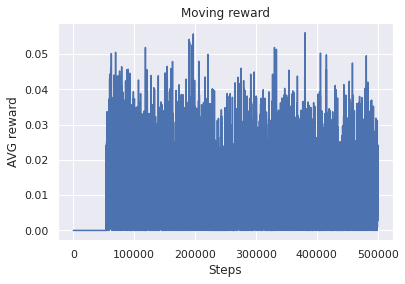

499922it [1:24:46, 87.20it/s] 

Average reward for 499900 step : 0.01


500000it [1:24:47, 98.28it/s] 

Training took : 84.79074329932531 min


In [56]:
bandit_1000_items_outer, reward_1000_items_outer = train(generator,user_feature_buffer,user_hist_buffer,
          feature_processing,transformed_features, items_1000,
          alpha=0.1, use_bias=False)

In [57]:
print('Mean reward for run : {}'.format(np.mean(reward_1000_items_outer)))
print('Mean CTR for run : {}%'.format(np.mean(reward_1000_items_outer)*100))

Mean reward for run : 0.006044
Mean CTR for run : 0.6043999999999999%


In [ ]:
step = 10000
train_curve_outer_1000 = [np.mean(reward_1000_items_outer[i:i+step]) for i in range(0,len(reward_1000_items_concat)+step, step)]
plt.figure(figsize=(15,12))
plt.plot(train_curve_outer_1000, 'or')
plt.plot(train_curve_outer_1000, 'r')
plt.title('Training curve 1000 items using outer feature')
plt.ylabel('CTR')
plt.xlabel('Epochs');